# Масштабирование графовых нейронных сетей с помощью GraphSAGE

In [1]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 27.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 32.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00


In [2]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def set_seed():
    """
    Задает стартовое значение генератора псевдослучайных
    чисел для воспроизводимости.
    """
    torch.manual_seed(-1)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)

## Pubmed

In [3]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# печатаем информацию о наборе данных
print(f'Набор данных: {dataset}')
print('---------------')
print(f'Количество графов: {len(dataset)}')
print(f'Количество узлов: {data.x.shape[0]}')
print(f'Количество признаков: {dataset.num_features}')
print(f'Количество классов: {dataset.num_classes}')

# печатаем информацию о графе
print(f'\nГраф:')
print('------')
print(f'Узлы для обучения: {sum(data.train_mask).item()}')
print(f'Узлы для валидации: {sum(data.val_mask).item()}')
print(f'Узлы для тестирования: {sum(data.test_mask).item()}')
print(f'Ребра являются ориентированными: {data.is_directed()}')
print(f'У графа есть изолированные узлы: {data.has_isolated_nodes()}')
print(f'У графа есть петли: {data.has_self_loops()}')

Processing...
Done!


Набор данных: Pubmed()
---------------
Количество графов: 1
Количество узлов: 19717
Количество признаков: 500
Количество классов: 3

Граф:
------
Узлы для обучения: 60
Узлы для валидации: 500
Узлы для тестирования: 1000
Ребра являются ориентированными: False
У графа есть изолированные узлы: False
У графа есть петли: False


In [4]:
from torch_geometric.loader import NeighborLoader

# создаем батчи с семплированием соседей
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# печатаем каждый подграф
for i, subgraph in enumerate(train_loader):
    print(f'Подграф {i}: {subgraph}')

Подграф 0: Data(x=[394, 500], edge_index=[2, 453], y=[394], train_mask=[394], val_mask=[394], test_mask=[394], n_id=[394], e_id=[453], input_id=[16], batch_size=16)
Подграф 1: Data(x=[265, 500], edge_index=[2, 311], y=[265], train_mask=[265], val_mask=[265], test_mask=[265], n_id=[265], e_id=[311], input_id=[16], batch_size=16)
Подграф 2: Data(x=[264, 500], edge_index=[2, 309], y=[264], train_mask=[264], val_mask=[264], test_mask=[264], n_id=[264], e_id=[309], input_id=[16], batch_size=16)
Подграф 3: Data(x=[197, 500], edge_index=[2, 227], y=[197], train_mask=[197], val_mask=[197], test_mask=[197], n_id=[197], e_id=[227], input_id=[12], batch_size=12)


/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


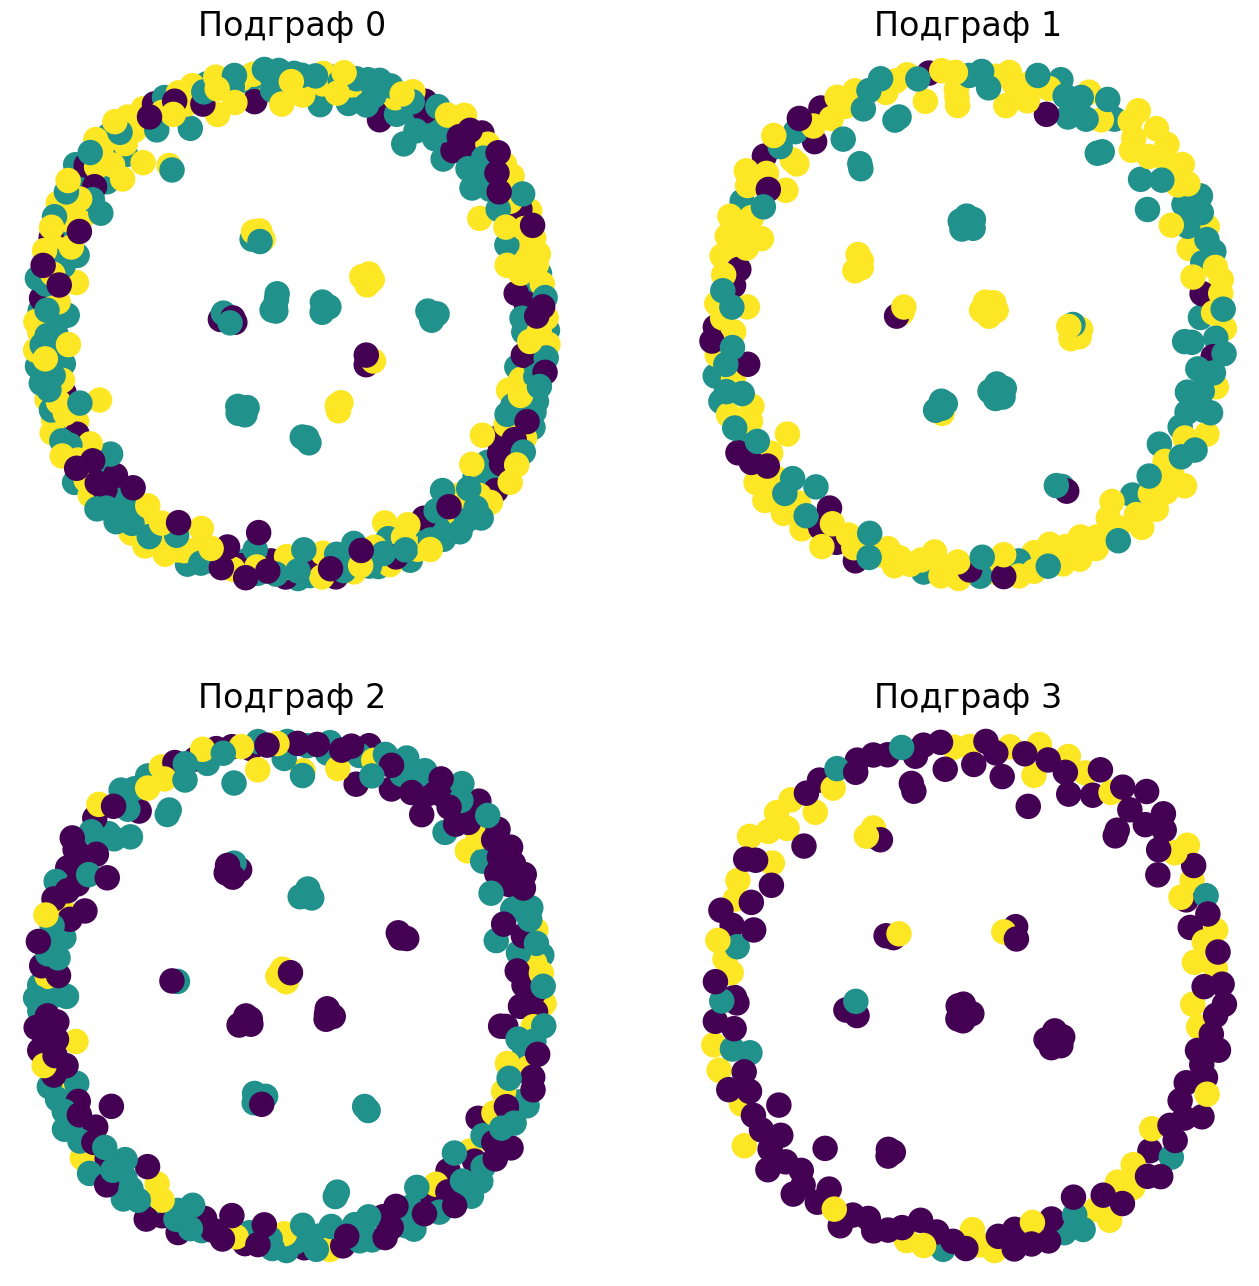

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# визуализируем каждый подграф
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Подграф {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_color=subdata.y,
                    )
plt.show()

In [6]:
def accuracy(pred_y, y):
    """Вычисляем правильность."""
    return ((pred_y == y).sum() / len(y)).item()

In [7]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h

    def fit(self, loader, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # обучаем на батчах
            for batch in loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask],
                                 batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1),
                                batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # валидируем
                val_loss += criterion(out[batch.val_mask],
                                      batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                                    batch.y[batch.val_mask])

            # печатаем функцию потерь и правильность каждые 20 итераций
            if epoch % 20 == 0:
                print(f'Эпоха {epoch:>3}:\n | Функция потерь на обуч. выборке: '
                      f'{loss/len(loader):.3f} | Правильность на обуч. выборке: '
                      f'{acc/len(loader)*100:>6.2f}%\n | Функция потерь на валид. '
                      f'выборке: {val_loss/len(train_loader):.2f}'
                      f'| Правильность на валид. выборке: '
                      f'{val_acc/len(train_loader)*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask],
                       data.y[data.test_mask])
        return acc

In [8]:
set_seed()

# создаем GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# обучаем
graphsage.fit(train_loader, 200)

# тестируем
acc = graphsage.test(data)
print(f'Правильность модели GraphSAGE на тесте: {acc*100:.2f}%')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Эпоха   0:
 | Функция потерь на обуч. выборке: 0.314 | Правильность на обуч. выборке:  28.77%
 | Функция потерь на валид. выборке: 1.12| Правильность на валид. выборке: 24.94%
Эпоха  20:
 | Функция потерь на обуч. выборке: 0.002 | Правильность на обуч. выборке: 100.00%
 | Функция потерь на валид. выборке: 0.67| Правильность на валид. выборке: 66.43%
Эпоха  40:
 | Функция потерь на обуч. выборке: 0.000 | Правильность на обуч. выборке: 100.00%
 | Функция потерь на валид. выборке: 0.52| Правильность на валид. выборке: 84.72%
Эпоха  60:
 | Функция потерь на обуч. выборке: 0.000 | Правильность на обуч. выборке: 100.00%
 | Функция потерь на валид. выборке: 0.64| Правильность на валид. выборке: 75.13%
Эпоха  80:
 | Функция потерь на обуч. выборке: 0.000 | Правильность на обуч. выборке: 100.00%
 | Функция потерь на валид. выборке: 0.45| Правильность на валид. выборке: 83.33%
Эпоха 100:
 | Функция потерь 

## PPI

In [9]:
set_seed()

from sklearn.metrics import f1_score

from torch_geometric.datasets import PPI
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphSAGE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# формируем обучающий, валидационный и тестовый наборы
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".", split='val')
test_dataset = PPI(root=".", split='test')

# объединяем графы обучающего набора
train_data = Batch.from_data_list(train_dataset)

# создаем батчи с семплированием соседей
train_loader = NeighborLoader(
    train_data, batch_size=2048,
    shuffle=True, num_neighbors=[20, 10],
    num_workers=2, persistent_workers=True
)

# создаем загрузчики данных для валидации и тестирования
# (два графа в батче)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

# задаем модель GraphSAGE
model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def fit(loader):
    model.train()

    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(loader.data)

@torch.no_grad()
def test(loader):
    model.eval()

    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))
    preds = (out > 0).float().cpu()

    y, pred = data.y.numpy(), preds.numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

for epoch in range(301):
    loss = fit(train_loader)
    val_f1 = test(val_loader)
    if epoch % 50 == 0:
        print(f'Эпоха {epoch:>3}:\n| Функция потерь на обуч. выборке: '
              f'{loss:.3f} | F1 на валид. выборке: {val_f1:.4f}')

print(f'F1 на тесте: {test(test_loader):.4f}')

Extracting ./ppi.zip
Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Эпоха   0:
| Функция потерь на обуч. выборке: 12.720 | F1 на валид. выборке: 0.4883
Эпоха  50:
| Функция потерь на обуч. выборке: 8.748 | F1 на валид. выборке: 0.7990
Эпоха 100:
| Функция потерь на обуч. выборке: 8.607 | F1 на валид. выборке: 0.8119
Эпоха 150:
| Функция потерь на обуч. выборке: 8.532 | F1 на валид. выборке: 0.8199
Эпоха 200:
| Функция потерь на обуч. выборке: 8.496 | F1 на валид. выборке: 0.8246
Эпоха 250:
| Функция потерь на обуч. выборке: 8.494 | F1 на валид. выборке: 0.8265
Эпоха 300:
| Функция потерь на обуч. выборке: 8.459 | F1 на валид. выборке: 0.8186
F1 на тесте: 0.8420
